## San Juan, Puerto Rico
This notebook contains some EDA (deeper than the eda.ipynb, and specific only to San Juan), and also some feature processing for San Juan.

There are also some preliminary baseline models using lagged features, although the purpose of this is just establishing baselines for this city.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
rawfeats = pd.read_csv('data/dengue_features_train.csv')
rawlabels = pd.read_csv('data/dengue_labels_train.csv')
rawfeats['total_cases'] = rawlabels['total_cases']
sj = rawfeats[rawfeats.city=='sj'].copy()
print(sj.shape)
sj.head()

(936, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


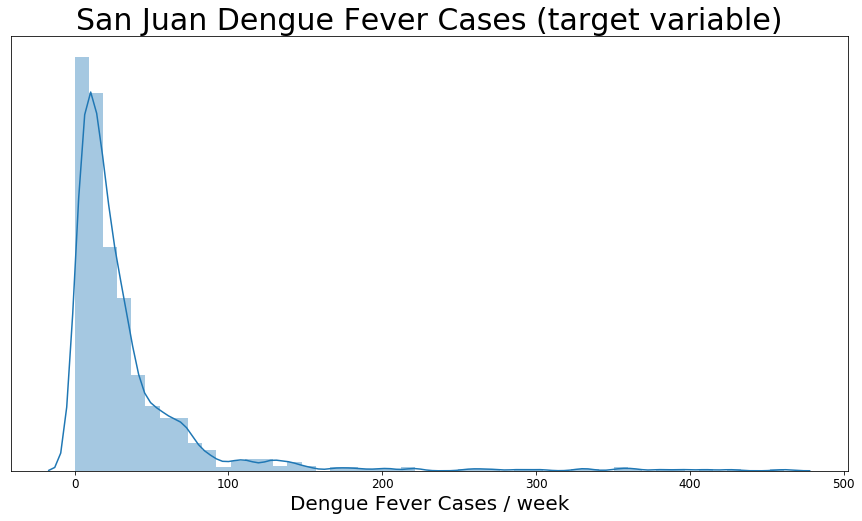

In [3]:
#Target variable
plt.figure(figsize=[15,8])
sns.distplot(sj.total_cases, bins=50)
plt.yticks([])
plt.xticks(size=12)
plt.title('San Juan Dengue Fever Cases (target variable)', size=30)
plt.xlabel('Dengue Fever Cases / week', size=20)
plt.show()

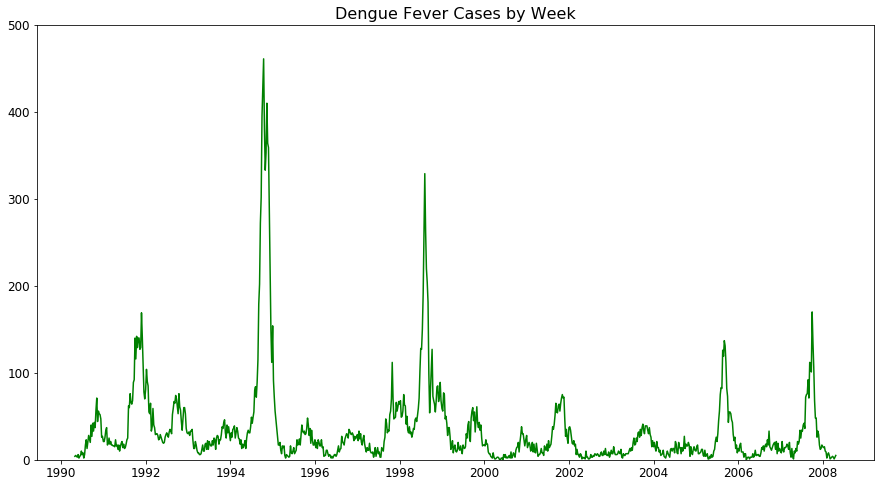

In [4]:
plt.figure(figsize=[15,8])
plt.title('Dengue Fever Cases by Week', size=16)
plt.plot(pd.to_datetime(sj.week_start_date), sj.total_cases, color='green')
#plt.xlim(['1990-01-01','2013-12-31' ])
plt.ylim([0,500])
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

## Date Issue & Correction
Some weeks have a mistaken weeknumber value, since the max for some years (ex 1993) is 53 despite still only having 52 unique weeks:

In [5]:
for year in sj.year.unique():
    print(f'{year} max: {max(sj[sj.year==year]["weekofyear"])}\
      | min: {min(sj[sj.year==year]["weekofyear"])}\
      | uniques: {sj[sj.year==year]["weekofyear"].nunique()}')

1990 max: 52      | min: 18      | uniques: 35
1991 max: 52      | min: 1      | uniques: 52
1992 max: 52      | min: 1      | uniques: 52
1993 max: 53      | min: 1      | uniques: 52
1994 max: 52      | min: 1      | uniques: 52
1995 max: 52      | min: 1      | uniques: 52
1996 max: 52      | min: 1      | uniques: 52
1997 max: 52      | min: 1      | uniques: 52
1998 max: 52      | min: 1      | uniques: 52
1999 max: 53      | min: 1      | uniques: 52
2000 max: 52      | min: 1      | uniques: 52
2001 max: 52      | min: 1      | uniques: 52
2002 max: 52      | min: 1      | uniques: 52
2003 max: 52      | min: 1      | uniques: 52
2004 max: 52      | min: 1      | uniques: 52
2005 max: 53      | min: 1      | uniques: 52
2006 max: 52      | min: 1      | uniques: 52
2007 max: 52      | min: 1      | uniques: 52
2008 max: 17      | min: 1      | uniques: 17


A closer look shows that it's the **first** week of the year that is registering as week 53:

In [6]:
for year in [1993,1999,2005]:
    display(sj[sj.year==year][['city','year','weekofyear','week_start_date']].head(3))

,city,year,weekofyear,week_start_date
139,sj,1993,53,1993-01-01
140,sj,1993,1,1993-01-08
141,sj,1993,2,1993-01-15


,city,year,weekofyear,week_start_date
451,sj,1999,53,1999-01-01
452,sj,1999,1,1999-01-08
453,sj,1999,2,1999-01-15


,city,year,weekofyear,week_start_date
763,sj,2005,53,2005-01-01
764,sj,2005,1,2005-01-08
765,sj,2005,2,2005-01-15


This can be corrected by two steps:
- incrementing all the week values by one. This would make the first week 54, and the rest of the weeks should be correct
- reduce any week values over 52 (i.e. the first week only) to 1.

In [7]:
#Increment all week values by one for all problem years
sj.loc[:,'weekofyear_fixed'] = np.where(sj.year==1993,sj.weekofyear+1, sj.weekofyear)
for year in [1994,1995,1999,2000,2005,2006]:
    sj.loc[:,'weekofyear_fixed'] = np.where(sj.year==year,sj.weekofyear_fixed+1, sj.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
sj.loc[:,'weekofyear_fixed'] = np.where(sj.weekofyear_fixed>52,1, sj.weekofyear_fixed)

#Check solution
for year in sj.year.unique():
    print(f'{year} max: {max(sj[sj.year==year]["weekofyear_fixed"])}\
  | min: {min(sj[sj.year==year]["weekofyear_fixed"])}\
  | uniques: {sj[sj.year==year]["weekofyear_fixed"].nunique()}')
#Much better!

1990 max: 52  | min: 18  | uniques: 35
1991 max: 52  | min: 1  | uniques: 52
1992 max: 52  | min: 1  | uniques: 52
1993 max: 52  | min: 1  | uniques: 52
1994 max: 52  | min: 1  | uniques: 52
1995 max: 52  | min: 1  | uniques: 52
1996 max: 52  | min: 1  | uniques: 52
1997 max: 52  | min: 1  | uniques: 52
1998 max: 52  | min: 1  | uniques: 52
1999 max: 52  | min: 1  | uniques: 52
2000 max: 52  | min: 1  | uniques: 52
2001 max: 52  | min: 1  | uniques: 52
2002 max: 52  | min: 1  | uniques: 52
2003 max: 52  | min: 1  | uniques: 52
2004 max: 52  | min: 1  | uniques: 52
2005 max: 52  | min: 1  | uniques: 52
2006 max: 52  | min: 1  | uniques: 52
2007 max: 52  | min: 1  | uniques: 52
2008 max: 17  | min: 1  | uniques: 17


### Correcting the Test Data as well

In [8]:
testdata = pd.read_csv('data/dengue_features_test.csv')
sjtest = testdata[testdata.city=='sj'].copy()

In [9]:
sjtest.loc[:,'weekofyear_fixed'] = np.where(sjtest.year==2010,
                                              sjtest.weekofyear+1, sjtest.weekofyear) 
for year in [2011,2012]:
    sjtest.loc[:,'weekofyear_fixed'] = np.where(sjtest.year==year,
                                                  sjtest.weekofyear_fixed+1, sjtest.weekofyear_fixed)
sjtest.loc[:,'weekofyear'] = np.where(sjtest.weekofyear_fixed>52,
                                        1, sjtest.weekofyear_fixed)

#Check solution
for year in sjtest.year.unique():
    print(f'{year} max: {max(sjtest[sjtest.year==year]["weekofyear"])}\
  | min: {min(sjtest[sjtest.year==year]["weekofyear"])}\
  | uniques: {sjtest[sjtest.year==year]["weekofyear"].nunique()}')

2008 max: 52  | min: 18  | uniques: 35
2009 max: 52  | min: 1  | uniques: 52
2010 max: 52  | min: 1  | uniques: 52
2011 max: 52  | min: 1  | uniques: 52
2012 max: 52  | min: 1  | uniques: 52
2013 max: 17  | min: 1  | uniques: 17


## Nan values
San Juan has a Nan values, which will have to be imputed:

In [10]:
sj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 26 columns):
city                                     936 non-null object
year                                     936 non-null int64
weekofyear                               936 non-null int64
week_start_date                          936 non-null object
ndvi_ne                                  745 non-null float64
ndvi_nw                                  887 non-null float64
ndvi_se                                  917 non-null float64
ndvi_sw                                  917 non-null float64
precipitation_amt_mm                     927 non-null float64
reanalysis_air_temp_k                    930 non-null float64
reanalysis_avg_temp_k                    930 non-null float64
reanalysis_dew_point_temp_k              930 non-null float64
reanalysis_max_air_temp_k                930 non-null float64
reanalysis_min_air_temp_k                930 non-null float64
reanalysis_precip_amt_kg_per_m2  

Since this is time series data, with even evenly spaced observations, we can use interpolation to estimate the missing values. I'll use a linear method here:

In [11]:
sj = sj.interpolate(method='linear')

# Feature Engineering 

In [12]:
#New Dataframe to hold the features that are chosen or engineered
feats = sj[['city', 'year', 'weekofyear_fixed', 'total_cases']].copy()

## Seasonality

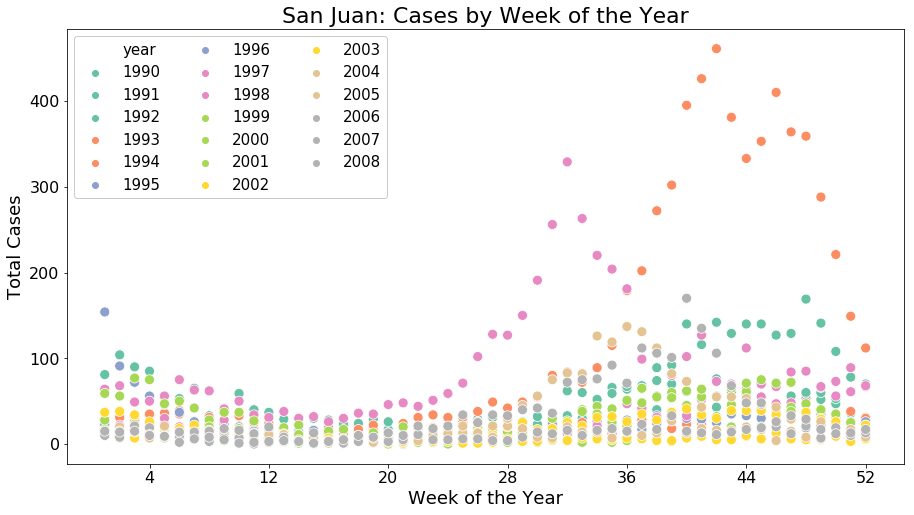

In [13]:
plt.figure(figsize=[15,8])
plt.title('San Juan: Cases by Week of the Year', size=22)
sns.scatterplot(x='weekofyear_fixed',y='total_cases', hue='year', s=100,
                data=sj, palette='Set2',legend='full')
plt.legend(loc=2, framealpha=1, ncol=3, prop={'size': 15})    
plt.ylabel('Total Cases',size=18)
plt.xlabel('Week of the Year',size=18)
plt.xticks([4,12,20,28,36,44,52], size=16)
plt.yticks(size=16)
plt.show()

There's enough seasonality here to consider making features out of the seasons. 

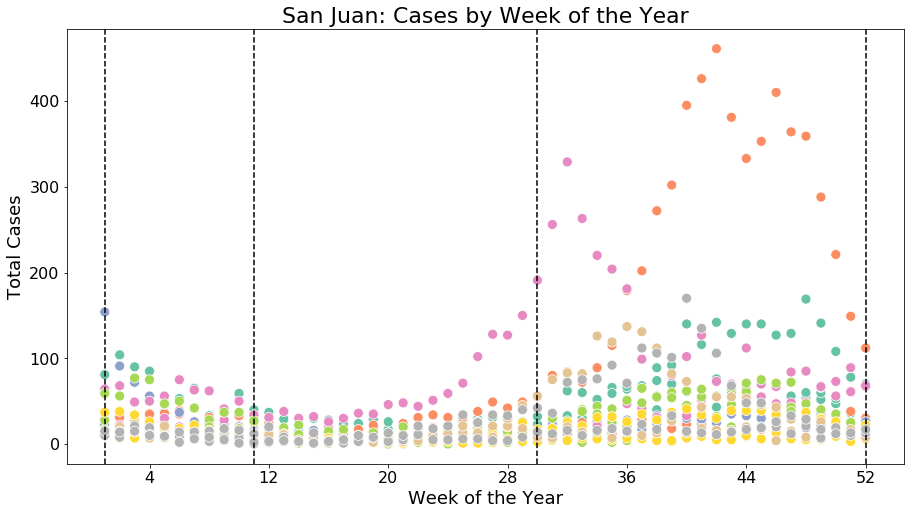

In [14]:
plt.figure(figsize=[15,8])
plt.title('San Juan: Cases by Week of the Year', size=22)
sns.scatterplot(x='weekofyear_fixed',y='total_cases', hue='year', s=100,
                data=sj, palette='Set2',legend=None)

plot_windows = [1,11,30,52]
for w in plot_windows:
    plt.axvline(w, linestyle='--',color='black')
plt.ylabel('Total Cases',size=18)
plt.xlabel('Week of the Year',size=18)
plt.xticks([4,12,20,28,36,44,52], size=16)
plt.yticks(size=16)
plt.show()

In [15]:
# Create categorical variable for each of the 3 seasons 
cutoffs = [11,30]
feats['winter'] = np.where((feats.weekofyear_fixed<cutoffs[0]), 1, 0)

feats['spring'] = np.where((feats.weekofyear_fixed>=cutoffs[0]) &
                           (feats.weekofyear_fixed<cutoffs[1]), 1, 0)
feats['summer'] = np.where((feats.weekofyear_fixed>=cutoffs[1]), 1, 0)

### Temperature - there are many temperature features, but they are remarkably similar

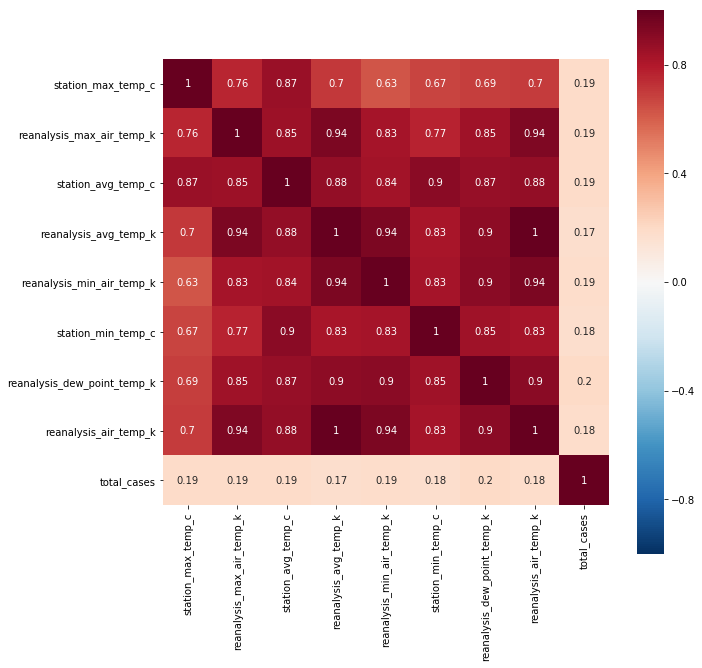

In [16]:
temps = sj[['station_max_temp_c',
            'reanalysis_max_air_temp_k',
            'station_avg_temp_c',
            'reanalysis_avg_temp_k',
            'reanalysis_min_air_temp_k',
            'station_min_temp_c',
            'reanalysis_dew_point_temp_k',
            'reanalysis_air_temp_k',
           'total_cases', ]].copy()
plt.figure(figsize=[10,10])
sns.heatmap(temps.corr(),square=True, vmin=-1, vmax=1, 
                center=0, cmap='RdBu_r', annot=True)
plt.show()

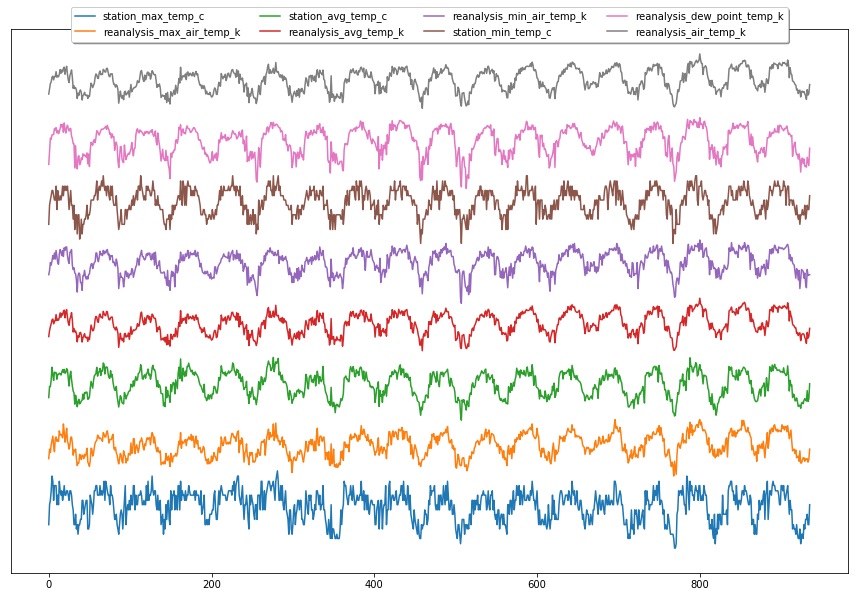

In [17]:
#Visually see the similarity in seasonality across all the training data temperature measurements
plt.figure(figsize=[15,10])
offset = 0
for i in temps:
    if i != 'total_cases':
        plt.plot(sj[i] - np.mean(sj[i]) + offset, label=i)
        offset+=7
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)
plt.yticks([])
plt.show()

In [18]:
temps['weekofyear'] = sj.weekofyear_fixed

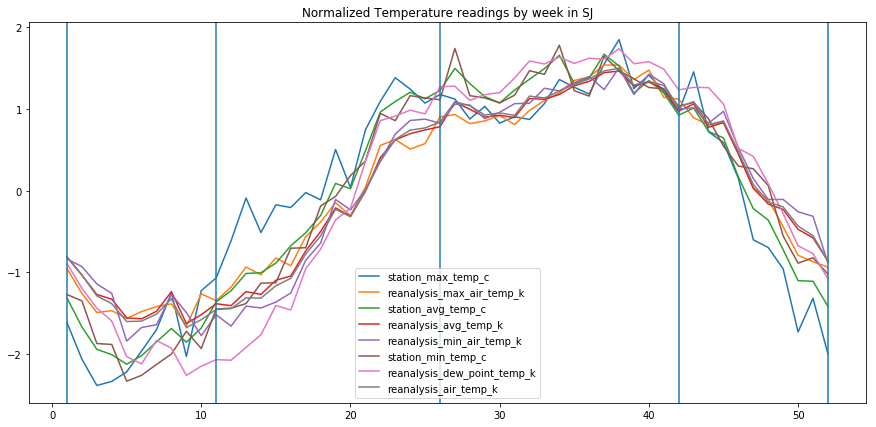

In [19]:
#All temperature readings averaged by week of the year
plt.figure(figsize=[15,7])
plt.title('Normalized Temperature readings by week in SJ')
for i in temps:
    if i != 'total_cases' and i != 'weekofyear':
        plt.plot(temps.groupby('weekofyear')[i].mean() - 
                 temps[i].mean(),
            label=i)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[11])
plt.axvline(x=[26])
plt.axvline(x=[42])
plt.axvline(x=[52])

plt.legend()
plt.show()

#### Conclusion: Temperature

Most of these temperature measurements are very correlated. I will keep station_max_temp_c, as that differs in a few key areas, but besides that I will simply average the rest after scaling them to be on the same range.

In [20]:
tempscols_to_average = sj.loc[:,['reanalysis_max_air_temp_k', 'station_avg_temp_c',
       'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_dew_point_temp_k',
       'reanalysis_air_temp_k']]

scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(tempscols_to_average), 
                            columns=tempscols_to_average.columns)

In [21]:
feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)
feats.loc[:,'station_max_temp_c'] = sj.station_max_temp_c

### Other temperature measurements and humidity

In [22]:
othertemps = ['total_cases','station_diur_temp_rng_c', 'reanalysis_tdtr_k','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg']
sj[othertemps].corr()

,total_cases,station_diur_temp_rng_c,reanalysis_tdtr_k,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg
total_cases,1.000000,0.035303,-0.067623,0.144404,0.206942
station_diur_temp_rng_c,0.035303,1.000000,0.372414,-0.193181,-0.057291
reanalysis_tdtr_k,-0.067623,0.372414,1.000000,-0.374547,-0.025810
reanalysis_relative_humidity_percent,0.144404,-0.193181,-0.374547,1.000000,0.673010
reanalysis_specific_humidity_g_per_kg,0.206942,-0.057291,-0.025810,0.673010,1.000000


##### Temperature Range appears mostly flat for San Juan, and it's seasonality should be captured by the temperature feature

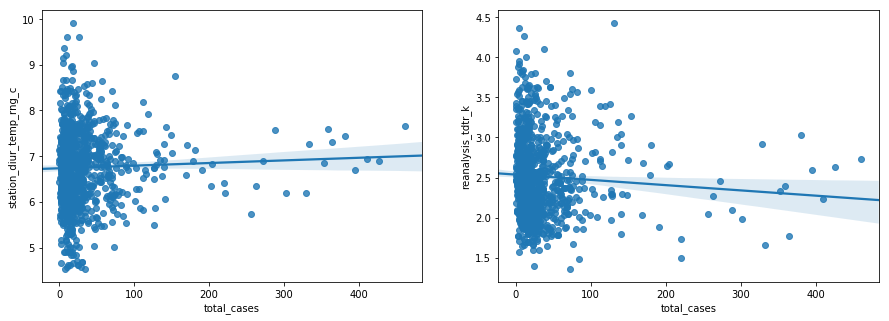

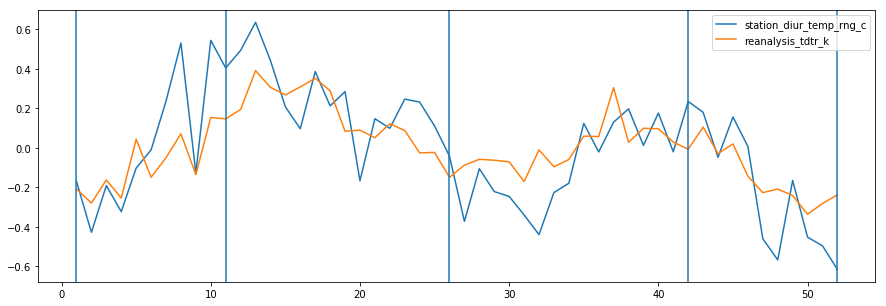

In [23]:
v = 'station_diur_temp_rng_c'
v2 = 'reanalysis_tdtr_k'

plt.figure(figsize=[15,5])
plt.subplot(121)
sns.regplot(sj.total_cases, sj[v])
plt.subplot(122)
sns.regplot(sj.total_cases, sj[v2])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(sj.groupby('weekofyear_fixed')[v].mean() - 
                 sj[v].mean(),
            label=v)

plt.plot(sj.groupby('weekofyear_fixed')[v2].mean() - 
                 sj[v2].mean(),
            label=v2)
#Approximations of seasons
plt.axvline(x=[1])
plt.axvline(x=[11])
plt.axvline(x=[26])
plt.axvline(x=[42])
plt.axvline(x=[52])
plt.legend()
plt.show()

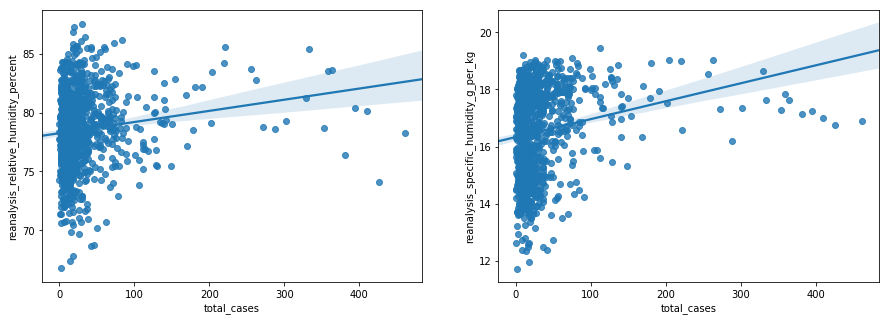

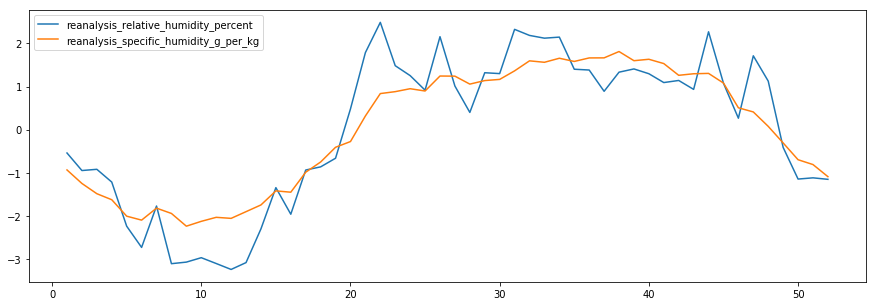

In [24]:
v = 'reanalysis_relative_humidity_percent'
v2 = 'reanalysis_specific_humidity_g_per_kg'

plt.figure(figsize=[15,5])
plt.subplot(121)
sns.regplot(sj.total_cases, sj[v])
plt.subplot(122)
sns.regplot(sj.total_cases, sj[v2])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(sj.groupby('weekofyear_fixed')[v].mean() - 
                 sj[v].mean(),
            label=v)

plt.plot(sj.groupby('weekofyear_fixed')[v2].mean() - 
                 sj[v2].mean(),
            label=v2)
plt.legend()
plt.show()

#### Conclusion: Humidity and temperature range

I will not include the temperature ranges. The humidity measurements appear to be useful and one is a more volatile version of the other. for now I will include them both, but I may consider PCA to combine them at a later point.

In [25]:
v = 'reanalysis_relative_humidity_percent'
v2 = 'reanalysis_specific_humidity_g_per_kg'
feats.loc[:,v] = sj[v]
feats.loc[:,v2] = sj[v2]

### Rain

In [26]:
rain = ['total_cases',
       'precipitation_amt_mm', 
       'reanalysis_precip_amt_kg_per_m2',
       #'reanalysis_sat_precip_amt_mm', # identical to precipitation_amt_mm
       'station_precip_mm']
sj[rain].corr()

,total_cases,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,station_precip_mm
total_cases,1.000000,0.060296,0.106939,0.051883
precipitation_amt_mm,0.060296,1.000000,0.508274,0.566660
reanalysis_precip_amt_kg_per_m2,0.106939,0.508274,1.000000,0.477984
station_precip_mm,0.051883,0.566660,0.477984,1.000000


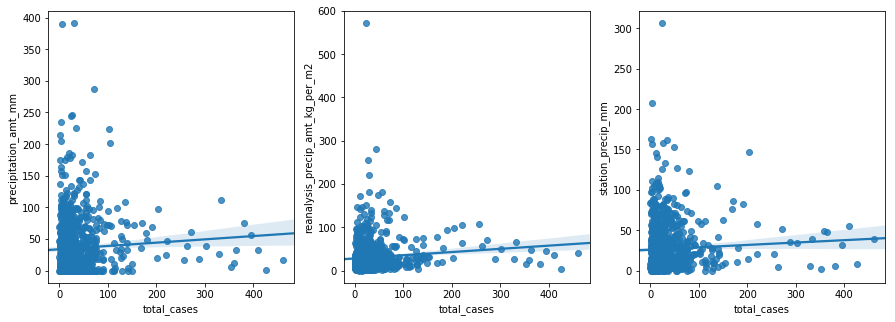

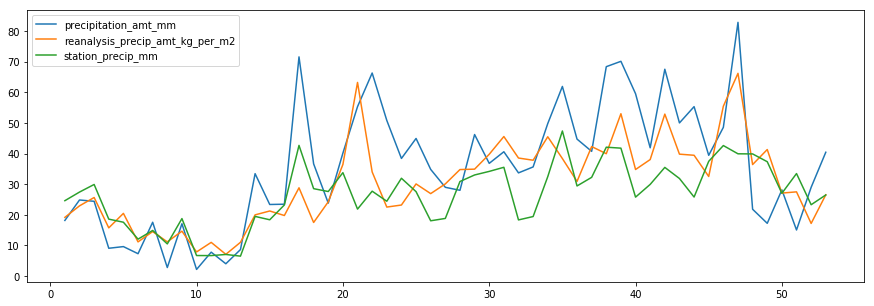

In [27]:
v = 'precipitation_amt_mm'
v2 = 'reanalysis_precip_amt_kg_per_m2'
v3 = 'station_precip_mm'

plt.figure(figsize=[15,5])
plt.subplot(131)
sns.regplot(sj.total_cases, sj[v])
plt.subplot(132)
sns.regplot(sj.total_cases, sj[v2])
plt.subplot(133)
sns.regplot(sj.total_cases, sj[v3])
plt.show()
plt.figure(figsize=[15,5])

plt.plot(sj.groupby('weekofyear')[v].mean(), 
            label=v)
plt.plot(sj.groupby('weekofyear')[v2].mean(),
            label=v2)
plt.plot(sj.groupby('weekofyear')[v3].mean(), 
            label=v3)

plt.legend()
plt.show()

#### Conclusion: Rain

I will include only the strongest correlated variable, reanalysis_precip_amt_kg_per_m2

In [28]:
v = 'reanalysis_precip_amt_kg_per_m2'
feats.loc[:,v] = sj[v]

### Vegetation

In [29]:
vegs = ['total_cases', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw']
sj[vegs].corr()

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw
total_cases,1.000000,0.085918,0.047403,-0.043680,0.042670
ndvi_ne,0.085918,1.000000,0.632660,0.219353,0.181035
ndvi_nw,0.047403,0.632660,1.000000,0.197311,0.217740
ndvi_se,-0.043680,0.219353,0.197311,1.000000,0.814621
ndvi_sw,0.042670,0.181035,0.217740,0.814621,1.000000


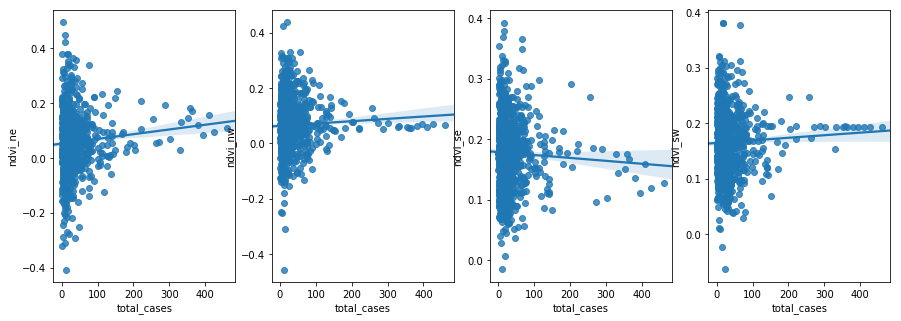

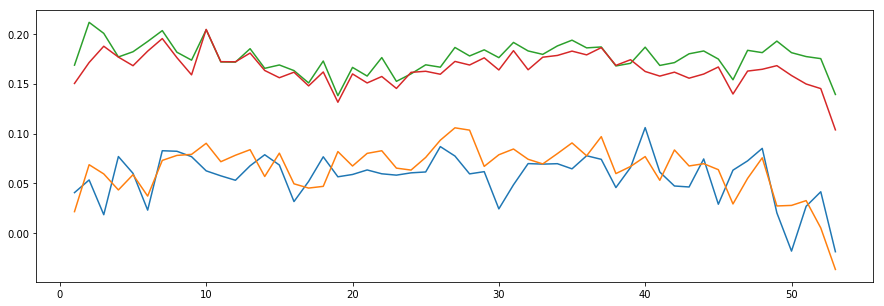

In [30]:
plt.figure(figsize=[15,5])
for i,col in enumerate(vegs[1:]):
    plt.subplot(1,4,i+1)
    sns.regplot(sj.total_cases, sj[col])
plt.show()

plt.figure(figsize=[15,5])
for v in vegs[1:]:
    plt.plot(sj.groupby('weekofyear')[v].mean(), 
            label=v)
plt.show()

#### Conclusion: Vegetation
Excluded - very little variability and no pearson correlation with the outcome variable

In [32]:
feats.head()

,city,year,weekofyear_fixed,total_cases,winter,spring,summer,temps_mean,station_max_temp_c,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_precip_amt_kg_per_m2
0,sj,1990,18,4,0,1,0,0.324516,29.4,73.365714,14.012857,32.00
1,sj,1990,19,5,0,1,0,0.481929,31.7,77.368571,15.372857,17.94
2,sj,1990,20,4,0,1,0,0.551015,32.2,82.052857,16.848571,26.10
3,sj,1990,21,3,0,1,0,0.599826,33.3,80.337143,16.672857,13.90
4,sj,1990,22,6,0,1,0,0.692043,35.0,80.460000,17.210000,12.20


# "Vanilla" Supervised Modelling Exploration:
Could supervised techniques find a pattern in this data? with chosen features? The point of this exploration is to see which models might be useable for Lagged Features technique.

In [31]:
def examine(y_pred, y_test):
    c = pd.DataFrame({
        'y' : y_test,
        'p' : y_pred
     })
    c = c.sort_index()
    plt.figure(figsize=[15,4])
    plt.plot(c.y, color='green')
    plt.plot(c.p, color='red')
    plt.show()

In [33]:
X = feats.drop(['total_cases', 'city', 'year', 'weekofyear_fixed', 'winter'], axis=1)
y = feats.total_cases

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(655, 7)
(281, 7)


#### Linear Regression

In [35]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-12.5968865  -14.39161275 -16.92243091]
20.581053278851464


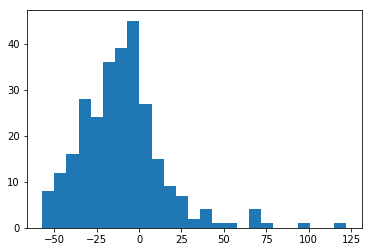

In [36]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

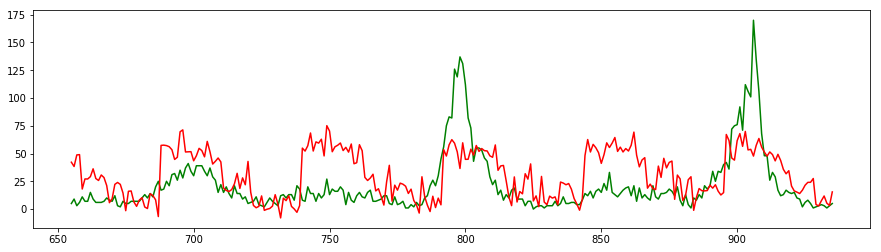

In [37]:
examine(y_pred, y_test)

### Random Forest Regressor

In [38]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=200, criterion='mae')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

27.185658362989326
[ -9.04547872 -15.46824468 -18.57188172]


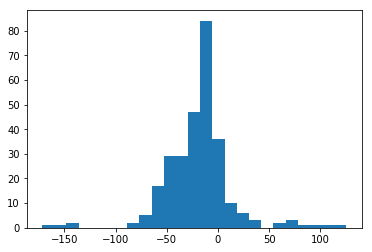

In [39]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

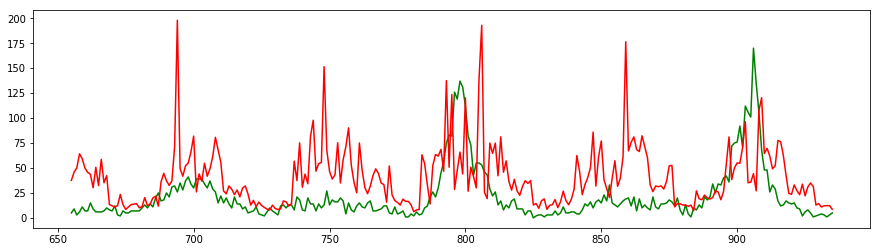

In [40]:
examine(y_pred, y_test)

### KNN Regressor

In [41]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

25.910370153338384
[-13.80718601 -17.19350758 -18.58860148]


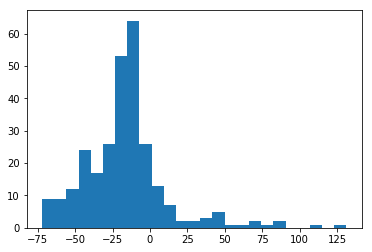

In [42]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

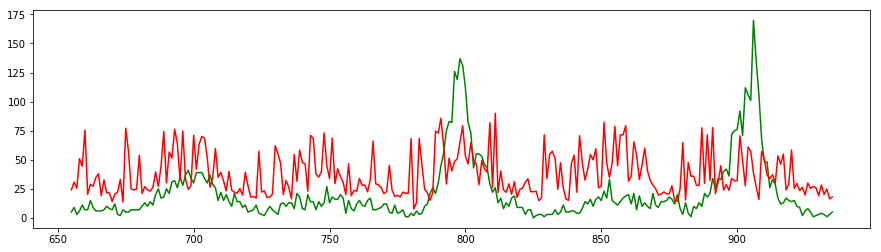

In [43]:
examine(y_pred, y_test)

###  Gradient Boosting Regressor

In [44]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=2,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

22.345924847814885
[ -7.824581   -17.2032783  -17.60961685]


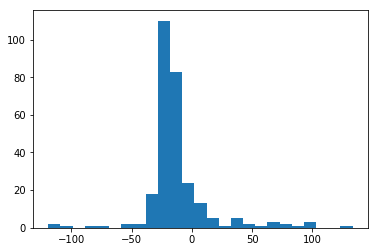

In [45]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

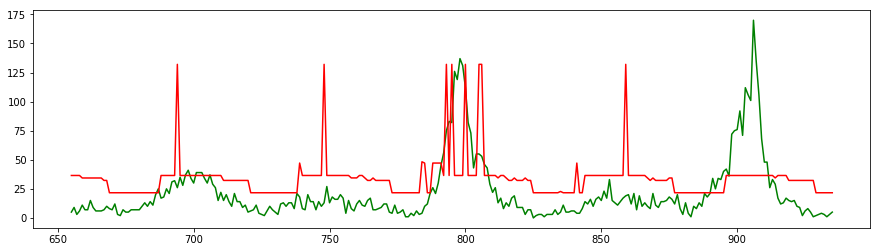

In [46]:
examine(y_pred, y_test)

###  Support Vector Regression

In [47]:
svr = SVR(gamma='auto')
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(svr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

17.609698067376236
[ -7.58991986 -17.60669383 -17.61676125]


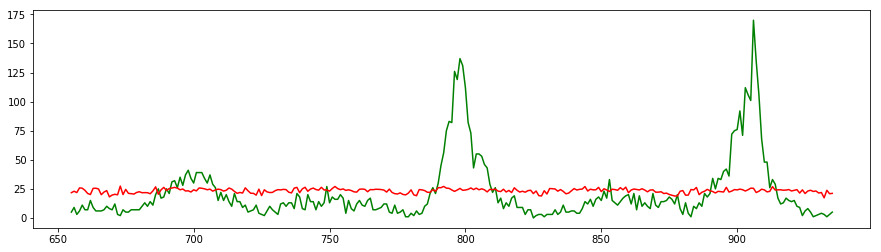

In [48]:
examine(y_pred, y_test)

### Negative Binomial Regression

In [49]:
smX_train = X_train.copy()
smX_train.loc[:,'total_cases'] = y_train
smX_test = X_test.copy()
smX_test.loc[:,'total_cases'] = y_test

In [50]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ spring + summer + temps_mean + station_max_temp_c + reanalysis_relative_humidity_percent + reanalysis_specific_humidity_g_per_kg + reanalysis_precip_amt_kg_per_m2'

In [51]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [52]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

19.16725978647687

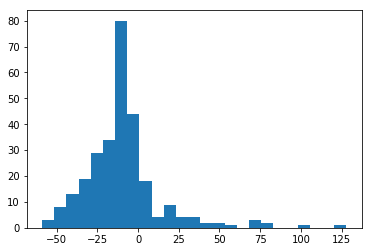

In [53]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

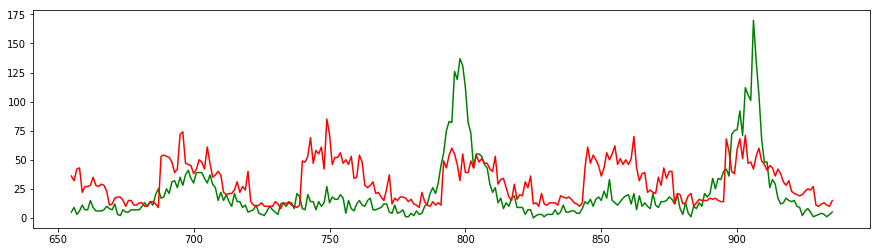

In [54]:
examine(predictions, y_test)

## Lagged Features: Supervised Learning Models with Time Series Data

In [55]:
sjshiftedfeats = feats[['city', 'year', 'weekofyear_fixed', 'total_cases',
                      'winter', 'spring', 'summer']].copy()
for i in ['station_max_temp_c', 'temps_mean',
          'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_precip_amt_kg_per_m2']:
    
    #Each sample gets 3 weeks of history as features
    sjshiftedfeats[i] = feats[i]
    sjshiftedfeats[i+'_1lag'] = feats[i].shift(-1)
    sjshiftedfeats[i+'_2lag'] = feats[i].shift(-2)
    sjshiftedfeats[i+'_3lag'] = feats[i].shift(-3)

sjshiftedfeats = sjshiftedfeats.fillna(method='ffill')
sjshiftedfeats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 27 columns):
city                                          936 non-null object
year                                          936 non-null int64
weekofyear_fixed                              936 non-null int64
total_cases                                   936 non-null int64
winter                                        936 non-null int32
spring                                        936 non-null int32
summer                                        936 non-null int32
station_max_temp_c                            936 non-null float64
station_max_temp_c_1lag                       936 non-null float64
station_max_temp_c_2lag                       936 non-null float64
station_max_temp_c_3lag                       936 non-null float64
temps_mean                                    936 non-null float64
temps_mean_1lag                               936 non-null float64
temps_mean_2lag                      

In [56]:
X = sjshiftedfeats.drop(['total_cases', 'city', 'year', 'weekofyear_fixed'], axis=1)
y = sjshiftedfeats.total_cases

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(655, 23)
(281, 23)


#### Linear Regression

In [58]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
print(cross_val_score(regr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))

[-14.72337297 -15.39628338 -16.93698523]
20.0130037953075


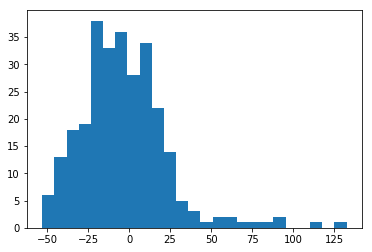

In [59]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

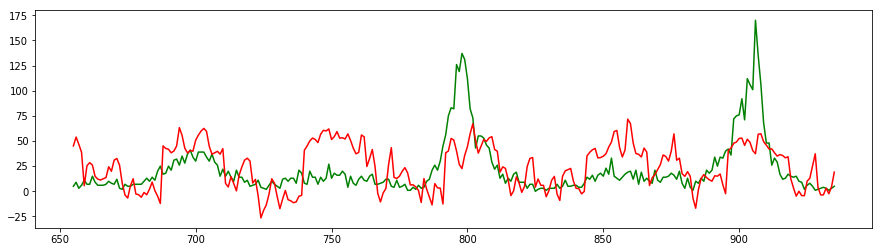

In [60]:
examine(y_pred, y_test)

### Random Forest Regressor

In [61]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=200, criterion='mse')
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(rfr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

25.62085409252669
[ -8.10117021 -15.69361702 -18.1627957 ]


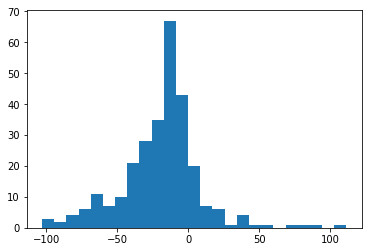

In [62]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

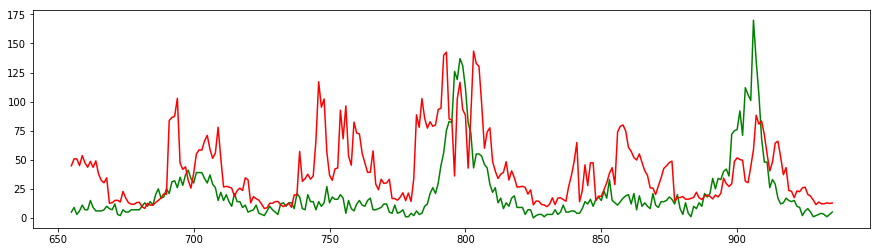

In [63]:
examine(y_pred, y_test)

In [64]:
[(X_train.columns[i], rfr.feature_importances_[i]) for i in range(len(X_train.columns))]

[('winter', 0.005683388734819862),
 ('spring', 0.017124118645959478),
 ('summer', 0.08549932348239146),
 ('station_max_temp_c', 0.0721263075004527),
 ('station_max_temp_c_1lag', 0.05764197109808984),
 ('station_max_temp_c_2lag', 0.06925969787524183),
 ('station_max_temp_c_3lag', 0.04987063986722678),
 ('temps_mean', 0.021642836389146325),
 ('temps_mean_1lag', 0.023629178959702842),
 ('temps_mean_2lag', 0.02744745017782706),
 ('temps_mean_3lag', 0.027303651964850344),
 ('reanalysis_relative_humidity_percent', 0.04010807233201504),
 ('reanalysis_relative_humidity_percent_1lag', 0.03624967511661309),
 ('reanalysis_relative_humidity_percent_2lag', 0.035940879525183905),
 ('reanalysis_relative_humidity_percent_3lag', 0.04192588851550752),
 ('reanalysis_specific_humidity_g_per_kg', 0.07569284064474305),
 ('reanalysis_specific_humidity_g_per_kg_1lag', 0.07040788229908071),
 ('reanalysis_specific_humidity_g_per_kg_2lag', 0.075839112719845),
 ('reanalysis_specific_humidity_g_per_kg_3lag', 0.061

### KNN Regressor

In [65]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(knn,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

24.460621683806426
[-15.08084072 -19.86669542 -18.39890671]


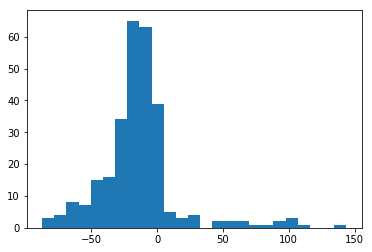

In [66]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

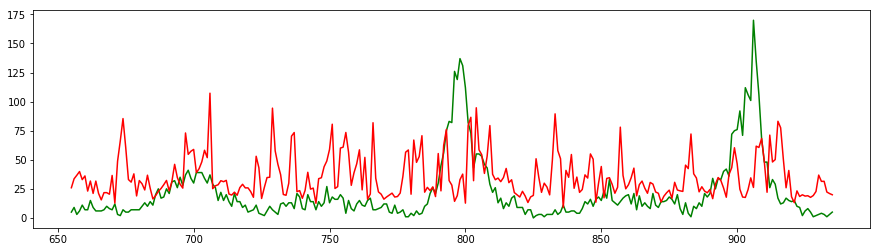

In [67]:
examine(y_pred, y_test)

###  Gradient Boosting Regressor

In [68]:
gbr = GradientBoostingRegressor(criterion='mae',max_depth=4,
                                learning_rate=.01, n_estimators=100)
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(gbr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

23.65019360432914
[-10.42676439 -17.22239648 -18.00538747]


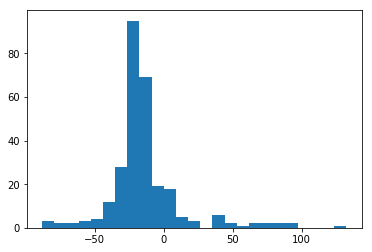

In [69]:
residual = y_test - y_pred
plt.hist(residual, bins=25)
plt.show()

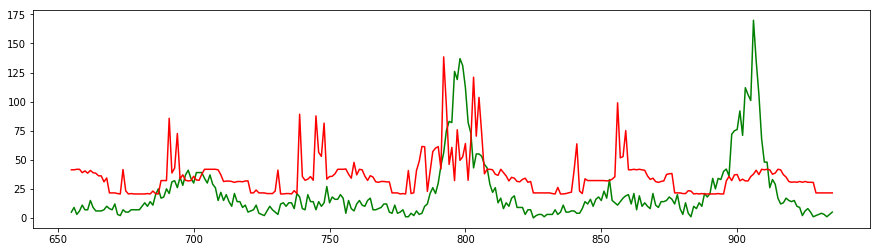

In [70]:
examine(y_pred, y_test)

###  Support Vector Regression

In [71]:
svr = SVR(gamma='scale', kernel='linear')
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
print(cross_val_score(svr,X_test,y_test,scoring='neg_mean_absolute_error', cv=3))

15.36649012502101
[ -6.99198455 -15.48721559 -16.68487487]


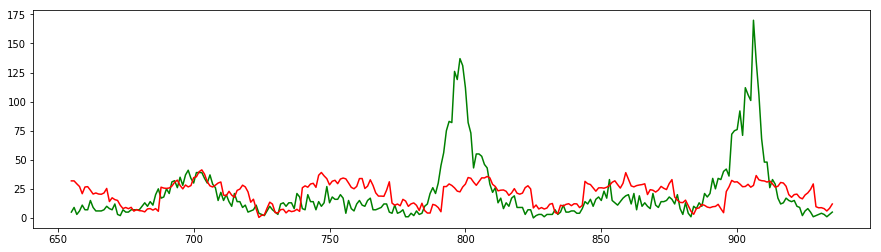

In [72]:
examine(y_pred, y_test)

### Negative Binomial Regression

In [73]:
smX_train = X_train.copy()
smX_train.loc[:,'total_cases'] = y_train
smX_test = X_test.copy()
smX_test.loc[:,'total_cases'] = y_test

In [74]:
#create statsmodels formula
formula = 'total_cases ~ '
for i in X.columns:
    formula = formula + str(i) + ' + '
formula =  formula[:-3] #trim the last plus sign
formula

'total_cases ~ winter + spring + summer + station_max_temp_c + station_max_temp_c_1lag + station_max_temp_c_2lag + station_max_temp_c_3lag + temps_mean + temps_mean_1lag + temps_mean_2lag + temps_mean_3lag + reanalysis_relative_humidity_percent + reanalysis_relative_humidity_percent_1lag + reanalysis_relative_humidity_percent_2lag + reanalysis_relative_humidity_percent_3lag + reanalysis_specific_humidity_g_per_kg + reanalysis_specific_humidity_g_per_kg_1lag + reanalysis_specific_humidity_g_per_kg_2lag + reanalysis_specific_humidity_g_per_kg_3lag + reanalysis_precip_amt_kg_per_m2 + reanalysis_precip_amt_kg_per_m2_1lag + reanalysis_precip_amt_kg_per_m2_2lag + reanalysis_precip_amt_kg_per_m2_3lag'

In [75]:
model = smf.glm(formula=formula, data=smX_train, 
               family=sm.families.NegativeBinomial(alpha=1e-6))

In [76]:
results = model.fit()
predictions = results.predict(smX_test).astype(int)
score = eval_measures.meanabs(predictions, smX_test.total_cases)
score

16.640569395017792

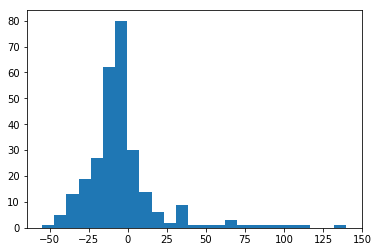

In [77]:
residual = y_test - predictions
plt.hist(residual, bins=25)
plt.show()

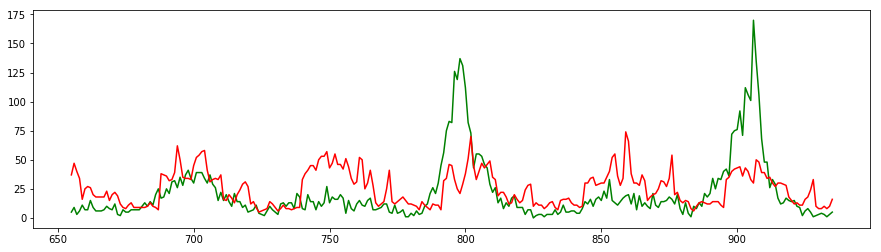

In [78]:
examine(predictions, y_test)